In [31]:
# import os
# os.chdir('tcr-covid-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_cluster_map, \
                            plot_clustermap_axes_based
from sklearn.manifold import TSNE, MDS

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/viz_utils.py'>

# Raw data prep

In [33]:
fmba_desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
fmba_desc['run'] = fmba_desc['run'].apply(lambda x: x.split('.')[0])
fmba_desc = fmba_desc[['run', 'folder', 'COVID_status']]
fmba_desc = fmba_desc[fmba_desc.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc.folder = fmba_desc.folder.apply(lambda x: x.split('_')[2])
fmba_desc

,run,folder,COVID_status
0,020000010808_S3_L001,NovaSeq5,COVID
1,020000110808_S14_L001,NovaSeq,COVID
2,020000190808_S27_L001,NovaSeq5,COVID
3,020000200808_S181_L002,NovaSeq5,healthy
4,020000280808_S59_L001,NovaSeq5,COVID
...,...,...,...
963,780008510808_S152_L002,NovaSeq3,COVID
964,780008550808_S150_L002,NovaSeq3,COVID
965,910000140808_S123_L002,NovaSeq2,COVID
966,910000320808_S121_L002,NovaSeq2,COVID


# Re-batched data prep

In [34]:
full = pd.read_csv('data/fmba_2021.txt', sep='\t')
full = full[full['file.name'].str.contains('TRB')]
full.COVID_status.value_counts()

COVID       761
healthy     376
precovid    103
Name: COVID_status, dtype: int64

In [35]:
fmba_desc_fixed = pd.read_csv('data/desc_fmba_new_split.csv').drop(columns=['Unnamed: 0'])
fmba_desc_fixed['run'] = fmba_desc_fixed['run'].apply(lambda x: x.split('.')[0])
fmba_desc_fixed = fmba_desc_fixed[['run', 'folder', 'COVID_status']]
fmba_desc_fixed = fmba_desc_fixed[fmba_desc_fixed.COVID_status != 'unknown'].replace({'precovid': 'healthy'})
fmba_desc_fixed.folder = fmba_desc_fixed.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
fmba_desc_fixed

,run,folder,COVID_status
0,020000010808_S3_L001,NovaSeq5,COVID
1,020000110808_S14_L001,NovaSeq14,COVID
2,020000190808_S27_L001,NovaSeq5,COVID
3,020000200808_S181_L002,NovaSeq5,healthy
4,020000280808_S59_L001,NovaSeq5,COVID
...,...,...,...
951,780008510808_S152_L002,NovaSeq34,COVID
952,780008550808_S150_L002,NovaSeq34,COVID
953,910000140808_S123_L002,NovaSeq24,COVID
954,910000320808_S121_L002,NovaSeq24,COVID


In [36]:
fmba_desc_fixed.COVID_status.value_counts()

COVID      661
healthy    295
Name: COVID_status, dtype: int64

# Biological biases PCA, β chain samples

In [37]:
um_norm = pd.read_csv('data/normalized_usage_matrix_fmba_TRB.csv').drop(columns=['Unnamed: 0'])
um_stand_log_exp = pd.read_csv('data/standardized_usage_matrix_fmba_TRB.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [38]:
um_norm.run = um_norm.run.apply(lambda x: x.split('.')[0])
um_norm = um_norm.merge(fmba_desc)
um_norm

,run,project,covid,hla,number_of_clonotypes,TRBV7-6,TRBV23-1,TRBV25-1,TRBV4-3,TRBV7-4,...,TRBV15,TRBV6-6,TRBV7-9,TRBV10-1,TRBV6-3,TRBV30,TRBV5-3,TRBV14,folder,COVID_status
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,A*24:02,4324,0.012488,0.008557,0.008326,0.000231,0.001156,...,0.000925,0.016651,0.032609,0.010407,0.000000,0.031684,0.004163,0.015032,NovaSeq5,COVID
1,020000110808_S14_L001,2020/09_FMBA_NovaSeq_DNA,covid,A*11:01,13264,0.012440,0.008142,0.008595,0.016134,0.001432,...,0.003694,0.015229,0.037696,0.008519,0.000000,0.023598,0.002790,0.013043,NovaSeq,COVID
2,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,A*32:01,16977,0.012134,0.007834,0.010308,0.014490,0.001296,...,0.003947,0.014078,0.042175,0.007245,0.000059,0.030335,0.003357,0.013783,NovaSeq5,COVID
3,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,A*11:01,14220,0.009564,0.005134,0.005767,0.015823,0.002532,...,0.002883,0.017229,0.039803,0.008158,0.000000,0.034810,0.003516,0.008861,NovaSeq5,healthy
4,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,A*02:01,6144,0.008952,0.009277,0.006185,0.015462,0.001628,...,0.003092,0.023112,0.037435,0.009277,0.000000,0.034180,0.002279,0.010905,NovaSeq5,COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*11:01,7215,0.013306,0.004712,0.007623,0.000139,0.001525,...,0.000554,0.021483,0.037976,0.013721,0.000000,0.019543,0.003188,0.010118,NovaSeq3,COVID
952,780008550808_S150_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*25:01,8864,0.011958,0.009364,0.008010,0.015456,0.002031,...,0.003046,0.016584,0.037116,0.009477,0.000000,0.027978,0.002708,0.011846,NovaSeq3,COVID
953,910000140808_S123_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*02:01,27443,0.009656,0.006996,0.008126,0.011733,0.001749,...,0.002041,0.019531,0.037241,0.008126,0.000000,0.017163,0.002952,0.012316,NovaSeq2,COVID
954,910000320808_S121_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*33:01,11451,0.010130,0.007510,0.006724,0.013973,0.001310,...,0.000699,0.024976,0.035717,0.013187,0.000000,0.018863,0.002009,0.010479,NovaSeq2,COVID


In [39]:
um_stand_log_exp.run = um_stand_log_exp.run.apply(lambda x: x.split('.')[0])
um_stand_log_exp = um_stand_log_exp.merge(fmba_desc)

In [40]:
um_stand_log_exp

,run,project,covid,hla,number_of_clonotypes,TRBV7-6,TRBV23-1,TRBV25-1,TRBV4-3,TRBV7-4,...,TRBV15,TRBV6-6,TRBV7-9,TRBV10-1,TRBV6-3,TRBV30,TRBV5-3,TRBV14,folder,COVID_status
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,A*24:02,4324,0.014570,0.010156,0.009460,0.008242,0.001463,...,0.001035,0.016448,0.015306,0.012147,0.000005,0.029322,0.003901,0.019247,NovaSeq5,COVID
1,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,A*32:01,16977,0.013754,0.008721,0.013493,0.017726,0.001559,...,0.003601,0.007964,0.053941,0.005090,0.000012,0.028799,0.003431,0.016965,NovaSeq5,COVID
2,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,A*11:01,14220,0.006897,0.002302,0.003227,0.017923,0.002098,...,0.003070,0.018387,0.045013,0.007263,0.000005,0.030433,0.003534,0.003689,NovaSeq5,healthy
3,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,A*02:01,6144,0.005345,0.011277,0.004118,0.017872,0.001749,...,0.003197,0.030533,0.034776,0.009889,0.000005,0.030220,0.002573,0.009081,NovaSeq5,COVID
4,020000340808_S82_L001,2020/10_FMBA_NovaSeq5,covid,A*30:02,7386,0.020328,0.002582,0.008622,0.001713,0.001034,...,0.003738,0.008367,0.045021,0.007181,0.000005,0.002889,0.004334,0.020178,NovaSeq5,COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780003510808_S92_L001,2020/10_FMBA_NovaSeq4,healthy,A*26:01,3645,0.003479,0.002285,0.002183,0.018899,0.002762,...,0.003841,0.024832,0.045781,0.011094,0.000005,0.022570,0.005510,0.023517,NovaSeq4,healthy
952,780003520808_S12_L001,2020/10_FMBA_NovaSeq4,healthy,A*32:01,8501,0.007531,0.007904,0.003869,0.001839,0.001836,...,0.004244,0.011167,0.041823,0.014401,0.000005,0.023459,0.000954,0.012631,NovaSeq4,healthy
953,780003890808_S35_L001,2020/10_FMBA_NovaSeq4,healthy,A*03:01,2436,0.013037,0.007721,0.007120,0.019574,0.000388,...,0.004301,0.006035,0.013290,0.003111,0.000005,0.025017,0.003585,0.011863,NovaSeq4,healthy
954,780003930808_S76_L001,2020/10_FMBA_NovaSeq4,healthy,A*26:01,3609,0.007590,0.005551,0.001444,0.017487,0.001860,...,0.002078,0.016532,0.011743,0.010105,0.000005,0.030219,0.003673,0.006875,NovaSeq4,healthy


In [41]:
um_norm.folder = um_norm.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_stand_log_exp.folder = um_stand_log_exp.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_norm['NovaSeq'] = um_norm.folder
um_stand_log_exp['NovaSeq'] = um_stand_log_exp.folder

In [42]:
um_norm

,run,project,covid,hla,number_of_clonotypes,TRBV7-6,TRBV23-1,TRBV25-1,TRBV4-3,TRBV7-4,...,TRBV6-6,TRBV7-9,TRBV10-1,TRBV6-3,TRBV30,TRBV5-3,TRBV14,folder,COVID_status,NovaSeq
0,020000010808_S3_L001,2020/10_FMBA_NovaSeq5,covid,A*24:02,4324,0.012488,0.008557,0.008326,0.000231,0.001156,...,0.016651,0.032609,0.010407,0.000000,0.031684,0.004163,0.015032,NovaSeq5,COVID,NovaSeq5
1,020000110808_S14_L001,2020/09_FMBA_NovaSeq_DNA,covid,A*11:01,13264,0.012440,0.008142,0.008595,0.016134,0.001432,...,0.015229,0.037696,0.008519,0.000000,0.023598,0.002790,0.013043,NovaSeq,COVID,NovaSeq
2,020000190808_S27_L001,2020/10_FMBA_NovaSeq5,covid,A*32:01,16977,0.012134,0.007834,0.010308,0.014490,0.001296,...,0.014078,0.042175,0.007245,0.000059,0.030335,0.003357,0.013783,NovaSeq5,COVID,NovaSeq5
3,020000200808_S181_L002,2020/10_FMBA_NovaSeq5,healthy,A*11:01,14220,0.009564,0.005134,0.005767,0.015823,0.002532,...,0.017229,0.039803,0.008158,0.000000,0.034810,0.003516,0.008861,NovaSeq5,healthy,NovaSeq5
4,020000280808_S59_L001,2020/10_FMBA_NovaSeq5,covid,A*02:01,6144,0.008952,0.009277,0.006185,0.015462,0.001628,...,0.023112,0.037435,0.009277,0.000000,0.034180,0.002279,0.010905,NovaSeq5,COVID,NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*11:01,7215,0.013306,0.004712,0.007623,0.000139,0.001525,...,0.021483,0.037976,0.013721,0.000000,0.019543,0.003188,0.010118,NovaSeq3,COVID,NovaSeq3
952,780008550808_S150_L002,2020/09_FMBA_NovaSeq3_DNA,covid,A*25:01,8864,0.011958,0.009364,0.008010,0.015456,0.002031,...,0.016584,0.037116,0.009477,0.000000,0.027978,0.002708,0.011846,NovaSeq3,COVID,NovaSeq3
953,910000140808_S123_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*02:01,27443,0.009656,0.006996,0.008126,0.011733,0.001749,...,0.019531,0.037241,0.008126,0.000000,0.017163,0.002952,0.012316,NovaSeq2,COVID,NovaSeq2
954,910000320808_S121_L002,2020/09_FMBA_NovaSeq2_DNA,covid,A*33:01,11451,0.010130,0.007510,0.006724,0.013973,0.001310,...,0.024976,0.035717,0.013187,0.000000,0.018863,0.002009,0.010479,NovaSeq2,COVID,NovaSeq2


<AxesSubplot:>

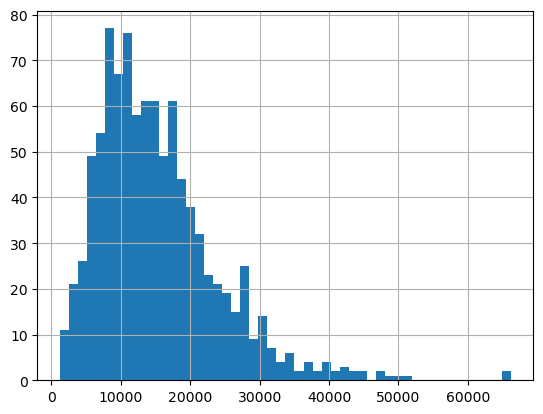

In [43]:
um_norm.number_of_clonotypes.hist(bins=50)

<AxesSubplot:>

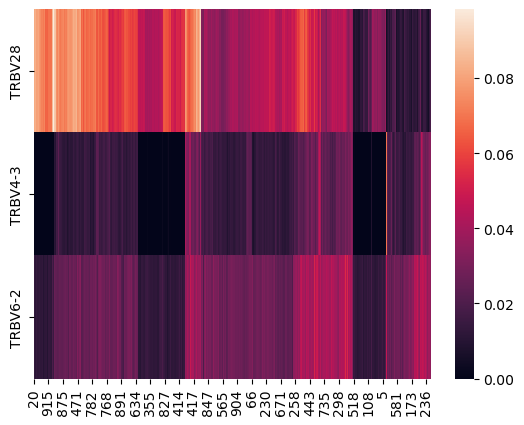

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

genes = ['TRBV28', 'TRBV4-3', 'TRBV6-2']
Z = linkage(um_norm[genes], 'complete')
labels = fcluster(Z, 0.00001, criterion='distance')
labels_order = np.argsort(labels)
sns.heatmap(um_norm.loc[labels_order, :][genes].T)

# α chain PCA before/after batch effect fixing

In [45]:
um_norm_alpha = pd.read_csv('data/normalized_usage_matrix_fmba_TRA.csv').drop(columns=['Unnamed: 0'])
um_stand_alpha = pd.read_csv('data/standardized_usage_matrix_fmba_TRA.csv').drop(columns=['Unnamed: 0'])

In [46]:
um_norm_alpha.run = um_norm_alpha.run.apply(lambda x: x.split('.')[0])
um_stand_alpha.run = um_stand_alpha.run.apply(lambda x: x.split('.')[0])
um_norm_alpha = um_norm_alpha.merge(fmba_desc)
um_stand_alpha = um_stand_alpha.merge(fmba_desc)
um_norm_alpha.folder = um_norm_alpha.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)
um_stand_alpha.folder = um_stand_alpha.folder.apply(lambda x: x.split('_')[2] if '_' in x else x)

In [47]:
um_norm_alpha['NovaSeq'] = um_norm_alpha.folder
um_stand_alpha['NovaSeq'] = um_stand_alpha.folder

# plotting

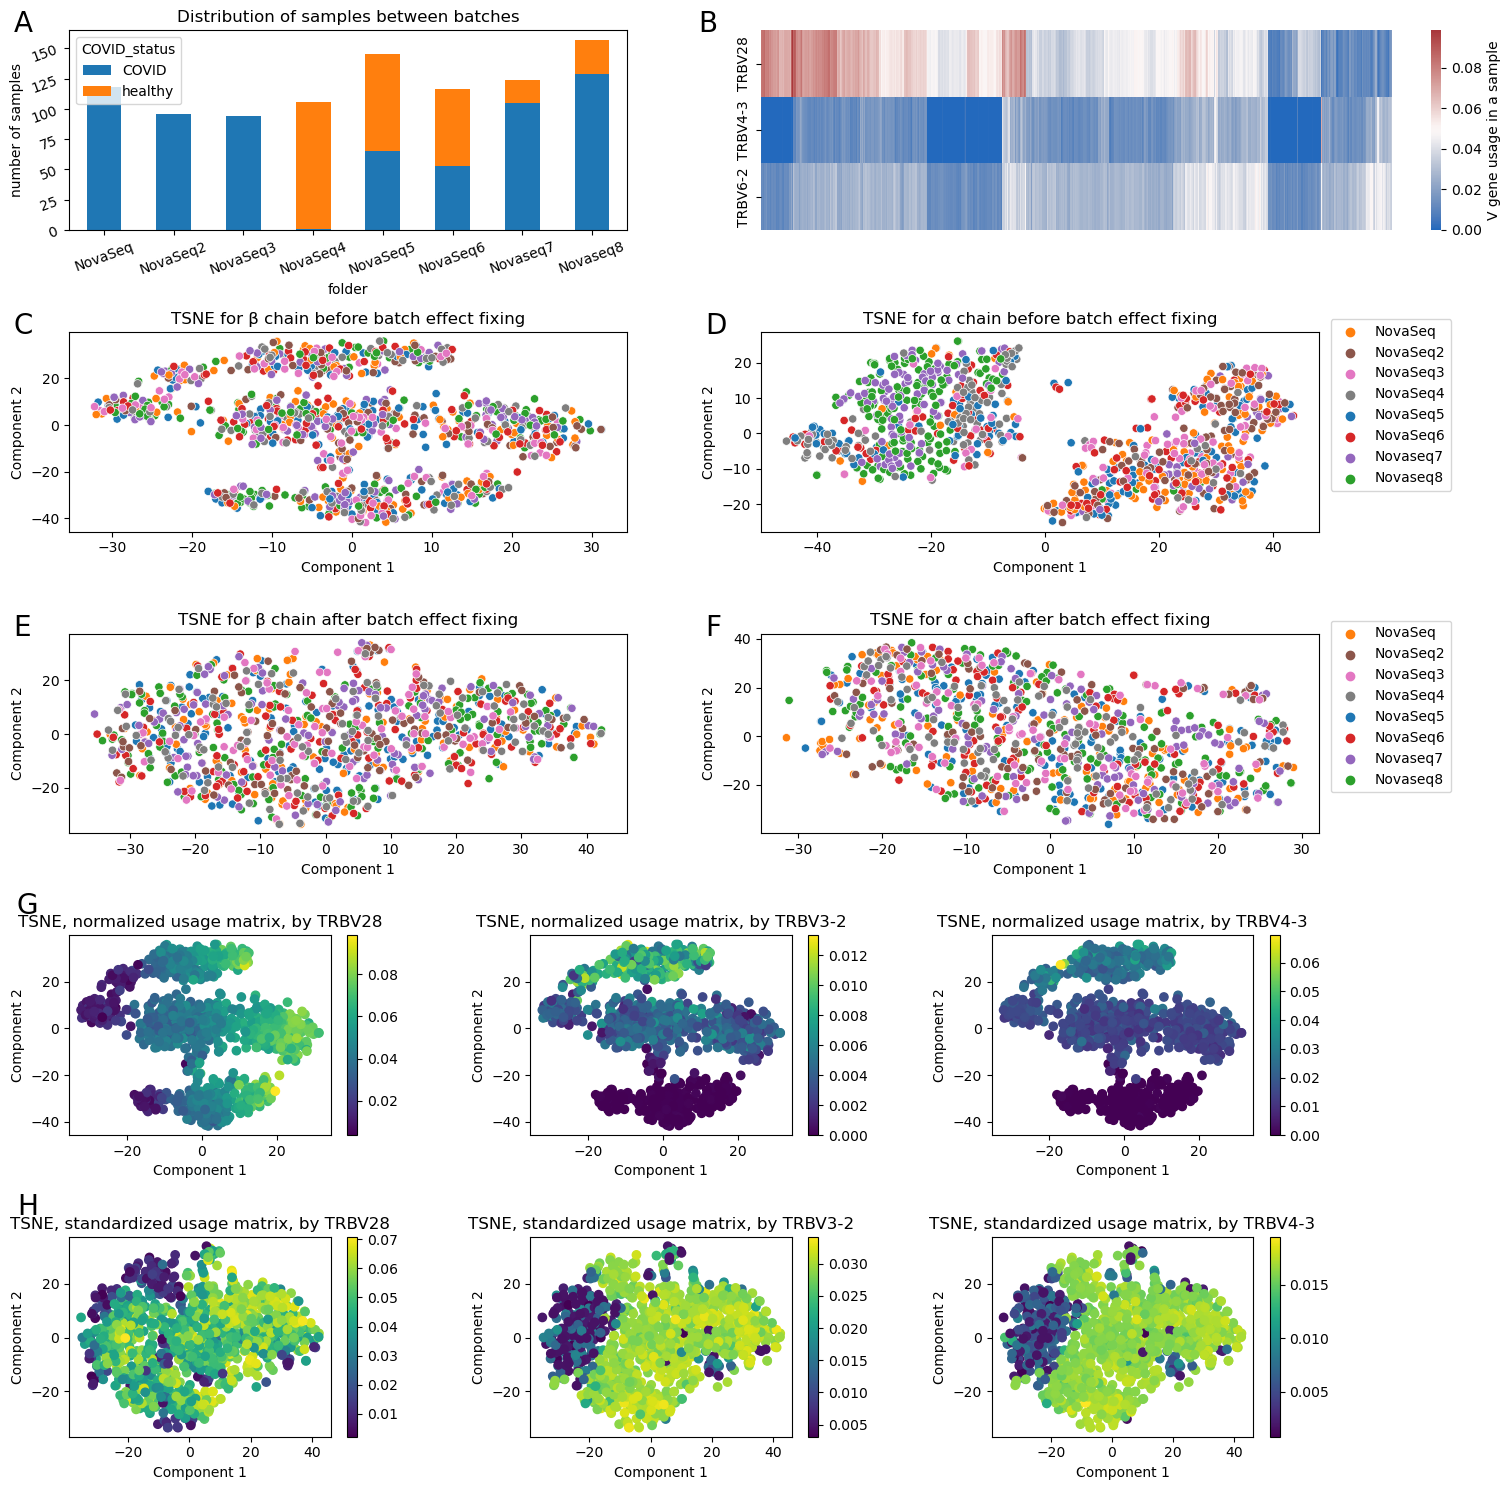

In [36]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(18, 15))
gs = GridSpec(nrows=5, 
              ncols=8)
font_size=20
delta_x=-0.1
delta_y=1.1

##############################################################################

ax0 = fig.add_subplot(gs[0, :3])
fmba_desc.groupby(['folder', 'COVID_status'], as_index=False).count().pivot(index='folder', 
                                                                            columns='COVID_status', 
                                                                            values='run').fillna(0).plot(kind='bar', stacked=True, ax=ax0)
ax0.set_ylabel('number of samples')
ax0.set_title('Distribution of samples between batches')
ax0.tick_params(labelrotation=20)
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

##############################################################################

ax1 = fig.add_subplot(gs[0, 3:7])
plot_clustermap_axes_based(um_norm, genes=['TRBV28', 'TRBV4-3', 'TRBV6-2'], ax=ax1)
ax1.text(delta_x, delta_y, 'B',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax1.transAxes,
         size=font_size)   

##############################################################################

ax10 = fig.add_subplot(gs[1, :3])
plot_usage_matrix_pca(um_norm, target='NovaSeq', ax=ax10, method=TSNE)
ax10.set_title('TSNE for β chain before batch effect fixing')
ax10.legend([],[], frameon=False)
ax10.text(delta_x, delta_y, 'C',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax10.transAxes,
         size=font_size)        

##############################################################################

ax11 = fig.add_subplot(gs[2, :3])
plot_usage_matrix_pca(um_stand_log_exp, target='NovaSeq', ax=ax11, method=TSNE)
ax11.set_title('TSNE for β chain after batch effect fixing')
ax11.text(delta_x, delta_y, 'E',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax11.transAxes,
         size=font_size)
ax11.legend([],[], frameon=False)

##############################################################################

ax8 = fig.add_subplot(gs[1, 3:6])
plot_usage_matrix_pca(um_norm_alpha, target='NovaSeq', ax=ax8, method=TSNE)
ax8.set_title('TSNE for α chain before batch effect fixing')
ax8.text(delta_x, delta_y, 'D',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax8.transAxes,
         size=font_size)        

handles, labels = ax8.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax8.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax8, "upper right", bbox_to_anchor=(1.25, 1.1))

##############################################################################

ax9 = fig.add_subplot(gs[2, 3:6])
plot_usage_matrix_pca(um_stand_alpha, target='NovaSeq', ax=ax9, method=TSNE)
ax9.set_title('TSNE for α chain after batch effect fixing')
ax9.text(delta_x, delta_y, 'F',
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax9.transAxes,
         size=font_size)
handles, labels = ax9.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])
ax9.legend([x[0] for x in pairs],[x[1] for x in pairs]) 
sns.move_legend(ax9, "upper right", bbox_to_anchor=(1.25, 1.1))

##############################################################################

for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[3, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_norm, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, normalized usage matrix, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'G',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)

##############################################################################
        
for i, v_gene in enumerate(['TRBV28', 'TRBV3-2', 'TRBV4-3']):
    ax_i = fig.add_subplot(gs[4, 2 * i: 2 * i + 2])
    plot_usage_matrix_pca(um_stand_log_exp, target=v_gene, plot_gradient=True, ax=ax_i, method=TSNE)
    ax_i.set_title(f'TSNE, standardized usage matrix, by {v_gene}')
    if i == 0:
        ax_i.text(delta_x-0.1, delta_y+0.12, 'H',
         horizontalalignment='left',
         verticalalignment='top',
        transform=ax_i.transAxes,
        size=font_size)
        
##############################################################################

        
plt.tight_layout()
plt.savefig("figures/fig1.svg")
plt.savefig("figures/fig1.pdf")
plt.savefig("figures/fig1.png")
plt.show()

Figure 1. Summary of COVID-19-convalescent and unexposed donor TCR sequencing dataset.

A. Distribution of convalescent and healthy donors across batches.

B. Imprint of TRBV28/3-2/4-3 haplotype on the dataset. Clustering in general is related to TRBV allele deletion.

C, D. Visualization of batch batch effect prior (C) and post (D) correction procedure for TRBV genes. Color shows sample batch. 

E, F. The same as C, D, but for TRAV genes.

G., H. TRBV28/3-2/4-3 haplotype effect remains in place after fixing for batch effect.


